In [62]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

import statistics as st

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [63]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/arnold/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/arnold/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/arnold/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [64]:
query = "(insurance OR insured OR insurer OR underwriter OR insure) -is:retweet near:Nairobi within:200km lang:en since:2020-01-01 until:2022-12-31"
tweets_list = []

In [65]:
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
   tweets_list.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])

In [66]:
insurance_list = pd.DataFrame(tweets_list,columns =["Date","Id","Content","Username"])
insurance_list.count()

Date        2855
Id          2855
Content     2855
Username    2855
dtype: int64

In [67]:
insurance_list["Date"] = pd.to_datetime(insurance_list["Date"]).dt.date
insurance_list.sort_values(by="Date",ascending=True,inplace=True)
insurance_list.head()

,Date,Id,Content,Username
2854,2020-01-02,1212788197161406469,"@MarvinGakunyi It has alot of humility in it, ...",dougladjuma
2853,2020-01-02,1212824415848804356,"HEALTHCARE FINANCING, @nhifkenya, ENHANCED NHI...",simonkigondu
2852,2020-01-02,1212831799052771328,This Cancer Insurance Cover by @icealion is wh...,drthuranira
2851,2020-01-03,1213057126802870273,@AutoxpressKenya to the rescue ⚒️ 🚗 after Tyre...,PhilipOgola
2849,2020-01-04,1213540436989616128,@JohnKieti @Ma3Route @PoliceKE No. It’s actual...,benliquidkenya


In [68]:
#Tweets preprocessing
insurance_list = insurance_list.dropna()
insurance_list = insurance_list.drop_duplicates()

#removing urls
cleaned_content = insurance_list['Content'].apply(lambda x:re.sub(r'https?:\/\/.*[\r\n]*','',x))

#extracting hashtags
hashtags = cleaned_content.apply(lambda x: re.findall(r"#(\w+)",x))

#Inserting space after period
cleaned_content = cleaned_content.apply(lambda x: re.sub(r'([a-z])\.([A-Z])', r'\1. \2', x))

#removing punctuation and whitespaces
cleaned_content = cleaned_content.apply(lambda x: re.sub(r'\n\s\s+','',x)).apply(lambda x: re.sub(r'[^\w\s]','',x)).apply(lambda x: str.lower(x))

#Tokenizing tweets
#tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
#cleaned_content = cleaned_content.apply(lambda x : tokenizer.tokenize(x))

#Removing stopwords
#stopwords_en = stopwords.words("english")

#cleaned_content = cleaned_content.apply(lambda words: [item for item in words if item not in stopwords_en])

#Lemmatizing the content
#wlm = WordNetLemmatizer()
#cleaned_content = cleaned_content.apply(lambda x: [wlm.lemmatize(word) for word in x ])
#cleaned_content.head()

#Extracting count per tweet
word_count = insurance_list["Content"].apply(lambda words: len(re.findall(r"\w+",words)))



In [69]:
insurance_list['Cleaned Content'] = cleaned_content
insurance_list['Hashtags'] = hashtags
insurance_list['Word Count'] = word_count
insurance_list.head()

,Date,Id,Content,Username,Cleaned Content,Hashtags,Word Count
2854,2020-01-02,1212788197161406469,"@MarvinGakunyi It has alot of humility in it, ...",dougladjuma,marvingakunyi it has alot of humility in it ho...,[],33
2853,2020-01-02,1212824415848804356,"HEALTHCARE FINANCING, @nhifkenya, ENHANCED NHI...",simonkigondu,healthcare financing nhifkenya enhanced nhif u...,[UHC],44
2852,2020-01-02,1212831799052771328,This Cancer Insurance Cover by @icealion is wh...,drthuranira,this cancer insurance cover by icealion is wha...,[],17
2851,2020-01-03,1213057126802870273,@AutoxpressKenya to the rescue ⚒️ 🚗 after Tyre...,PhilipOgola,autoxpresskenya to the rescue after tyre bur...,"[SocialGood, DigitalHumanitarian, ItCouldBeYou]",41
2849,2020-01-04,1213540436989616128,@JohnKieti @Ma3Route @PoliceKE No. It’s actual...,benliquidkenya,johnkieti ma3route policeke no its actually co...,[],50


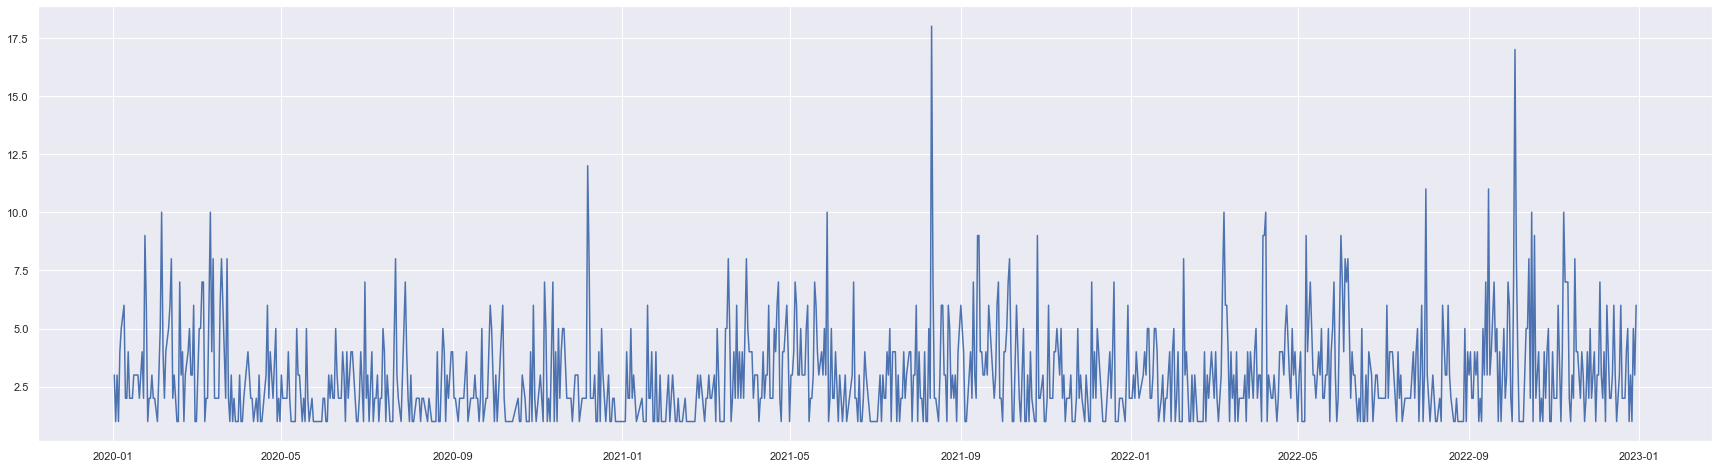

In [70]:
tweets_by_day = insurance_list.groupby("Date").count()
sns.set(rc={"figure.figsize":(30,8)})
plt.plot(tweets_by_day["Content"])
plt.show()

In [71]:
#Descriptive Statistics of the data
average = sum(tweets_by_day["Content"])/len(tweets_by_day["Content"])
median = st.median(tweets_by_day["Content"])
max_num = tweets_by_day["Content"].max()
min_num = tweets_by_day["Content"].min()
tweets_range = max_num - min_num

descriptive_stats = (["Mean",average],["Median",median],["Max",max_num],["Min",min_num],["Range",tweets_range])
descriptive_table = pd.DataFrame(descriptive_stats,columns=["Statistic","Values"])
descriptive_table


,Statistic,Values
0,Mean,3.00843
1,Median,2.00000
2,Max,18.00000
3,Min,1.00000
4,Range,17.00000


In [72]:
#TextBlob Model
def textblob_get_sentiment(text):
   text_blob_analyser = TextBlob(text)

   if text_blob_analyser.sentiment.polarity > 0:
      return "Positive"
   elif text_blob_analyser.sentiment.polarity == 0:
      return "Neutral"
   else:
      return "Negative"

textblob_tweet_sentiment = insurance_list["Cleaned Content"].apply(lambda text: textblob_get_sentiment(text))


#Vader Model
analyser = SentimentIntensityAnalyzer()
polarity_scores = insurance_list["Cleaned Content"].apply(lambda word: analyser.polarity_scores(word))
vader_sentiment_score = pd.concat([polarity_scores.apply(pd.Series)])
vader_sentiment_score.loc[vader_sentiment_score["compound"]== 0, "Label"] = "Neutral"
vader_sentiment_score.loc[vader_sentiment_score["compound"]> 0, "Label"] = "Positive"
vader_sentiment_score.loc[vader_sentiment_score["compound"]< 0, "Label"] = "Negative"
vader_sentiment_score.head()



,neg,neu,pos,compound,Label
2854,0.000,0.914,0.086,0.4404,Positive
2853,0.038,0.962,0.000,-0.1027,Negative
2852,0.292,0.560,0.148,-0.5574,Negative
2851,0.000,0.914,0.086,0.5106,Positive
2849,0.074,0.896,0.029,-0.2973,Negative


In [73]:
insurance_list["TextBlob Sentiment"] = textblob_tweet_sentiment
insurance_list["Vader Sentiment"] = vader_sentiment_score["Label"]
insurance_list

,Date,Id,Content,Username,Cleaned Content,Hashtags,Word Count,TextBlob Sentiment,Vader Sentiment
2854,2020-01-02,1212788197161406469,"@MarvinGakunyi It has alot of humility in it, ...",dougladjuma,marvingakunyi it has alot of humility in it ho...,[],33,Neutral,Positive
2853,2020-01-02,1212824415848804356,"HEALTHCARE FINANCING, @nhifkenya, ENHANCED NHI...",simonkigondu,healthcare financing nhifkenya enhanced nhif u...,[UHC],44,Neutral,Negative
2852,2020-01-02,1212831799052771328,This Cancer Insurance Cover by @icealion is wh...,drthuranira,this cancer insurance cover by icealion is wha...,[],17,Neutral,Negative
2851,2020-01-03,1213057126802870273,@AutoxpressKenya to the rescue ⚒️ 🚗 after Tyre...,PhilipOgola,autoxpresskenya to the rescue after tyre bur...,"[SocialGood, DigitalHumanitarian, ItCouldBeYou]",41,Neutral,Positive
2849,2020-01-04,1213540436989616128,@JohnKieti @Ma3Route @PoliceKE No. It’s actual...,benliquidkenya,johnkieti ma3route policeke no its actually co...,[],50,Negative,Negative
...,...,...,...,...,...,...,...,...,...
4,2022-12-30,1608655553730846720,can see if there is a survey that was done rec...,KenyansOnReddit,can see if there is a survey that was done rec...,[],46,Positive,Neutral
3,2022-12-30,1608733642301530112,"If you are comprehensively covered, then remem...",BimaTvKe,if you are comprehensively covered then rememb...,"[towing, comprehensive, insurance, accident, b...",36,Neutral,Negative
2,2022-12-30,1608760391974387713,What on this inflation and policy is my new In...,NyambuG,what on this inflation and policy is my new in...,[],11,Positive,Neutral
1,2022-12-30,1608795988327821312,A culture of doing routine checks should be in...,NairobiMedTech_,a culture of doing routine checks should be in...,[],17,Neutral,Neutral


In [75]:
positive_count = len(insurance_list[insurance_list["Vader Sentiment"] == "Positive"])
negative_count = len(insurance_list[insurance_list["Vader Sentiment"] == "Negative"])
neutral_count = len(insurance_list[insurance_list["Vader Sentiment"] == "Neutral"])
sentiment_data = (["Positive",positive_count],["Neutral",neutral_count],["Negative",negative_count])
sentiment_count = pd.DataFrame(sentiment_data,columns=["Sentiment","Count"])
sentiment_count

,Sentiment,Count
0,Positive,1357
1,Neutral,725
2,Negative,773


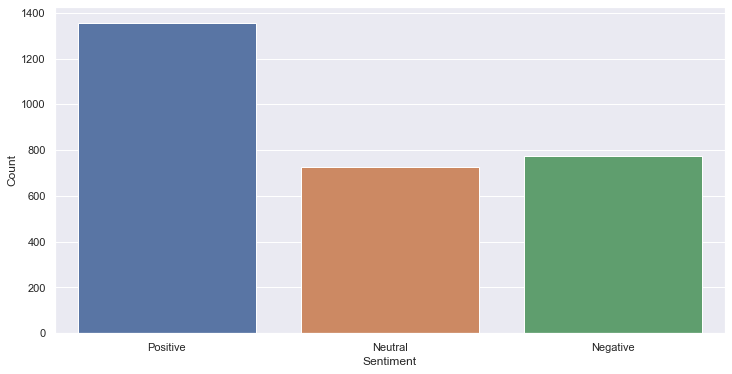

In [85]:
plt.figure(figsize=(12,6))
axis = sns.barplot(data = sentiment_count,x = "Sentiment",y="Count")
